#Test notebook Tripletloss Reconstructive Cifar10 dataset

##Before running this notebook, please ensure that the GPU is selected in the runtime option.

In [1]:
!git clone https://github.com/prakharsdev/Optics_Free_ImageClassification.git

Cloning into 'Optics_Free_ImageClassification'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 44 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), 107.33 MiB | 6.76 MiB/s, done.


In [2]:
!mkdir dataset

In [3]:
!unzip "/content/Optics_Free_ImageClassification/recontructive_image_test_dataset.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
 extracting: /content/dataset/test/dog_1000.PNG  
 extracting: /content/dataset/test/dog_101.PNG  
 extracting: /content/dataset/test/dog_1019.PNG  
 extracting: /content/dataset/test/dog_1025.PNG  
 extracting: /content/dataset/test/dog_1041.PNG  
 extracting: /content/dataset/test/dog_1042.PNG  
 extracting: /content/dataset/test/dog_1045.PNG  
 extracting: /content/dataset/test/dog_1055.PNG  
 extracting: /content/dataset/test/dog_1084.PNG  
 extracting: /content/dataset/test/dog_1097.PNG  
 extracting: /content/dataset/test/dog_1116.PNG  
 extracting: /content/dataset/test/dog_1117.PNG  
 extracting: /content/dataset/test/dog_1120.PNG  
 extracting: /content/dataset/test/dog_1138.PNG  
 extracting: /content/dataset/test/dog_1193.PNG  
 extracting: /content/dataset/test/dog_12.PNG  
 extracting: /content/dataset/test/dog_1214.PNG  
 extracting: /content/dataset/test/dog_1228.PNG  
 extracting: /content/dataset/test/dog_1230.PNG  
 e

In [4]:
import pandas as pd

# Set the file path
test_file_path = '/content/Optics_Free_ImageClassification/dataframe/test_rec_dataframe.csv'

# Load the CSV file into a pandas DataFrame
df_test = pd.read_csv(test_file_path)

In [5]:
df_test

,archor_img,postive_img,close_positive_img,negative_img,label,label_name
0,airplane_10.PNG,airplane_10.PNG,airplane_1001.PNG,truck_2071.PNG,0,airplane
1,airplane_1001.PNG,airplane_1001.PNG,airplane_1010.PNG,dog_1999.PNG,0,airplane
2,airplane_1010.PNG,airplane_1010.PNG,airplane_1018.PNG,truck_816.PNG,0,airplane
3,airplane_1018.PNG,airplane_1018.PNG,airplane_1022.PNG,frog_6042.PNG,0,airplane
4,airplane_1022.PNG,airplane_1022.PNG,airplane_1023.PNG,cat_2878.PNG,0,airplane
...,...,...,...,...,...,...
9985,truck_9884.PNG,truck_9884.PNG,truck_9898.PNG,cat_1607.PNG,9,truck
9986,truck_9898.PNG,truck_9898.PNG,truck_9927.PNG,cat_1625.PNG,9,truck
9987,truck_9927.PNG,truck_9927.PNG,truck_9938.PNG,ship_9115.PNG,9,truck
9988,truck_9938.PNG,truck_9938.PNG,truck_9958.PNG,deer_5317.PNG,9,truck


In [6]:
df_test = df_test.sample(frac = 1)

In [7]:
df_test

,archor_img,postive_img,close_positive_img,negative_img,label,label_name
9950,truck_9643.PNG,truck_9643.PNG,truck_9658.PNG,horse_9671.PNG,9,truck
1147,automobile_2334.PNG,automobile_2334.PNG,automobile_2345.PNG,bird_1575.PNG,1,automobile
8307,ship_3803.PNG,ship_3803.PNG,ship_3807.PNG,deer_6887.PNG,8,ship
3920,cat_9201.PNG,cat_9201.PNG,cat_9218.PNG,airplane_854.PNG,3,cat
2898,bird_9039.PNG,bird_9039.PNG,bird_9040.PNG,ship_5972.PNG,2,bird
...,...,...,...,...,...,...
919,airplane_9356.PNG,airplane_9356.PNG,airplane_9392.PNG,deer_8244.PNG,0,airplane
1559,automobile_6159.PNG,automobile_6159.PNG,automobile_6166.PNG,horse_375.PNG,1,automobile
4418,deer_465.PNG,deer_465.PNG,deer_4659.PNG,truck_922.PNG,4,deer
3105,cat_2034.PNG,cat_2034.PNG,cat_2044.PNG,airplane_6676.PNG,3,cat


In [8]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.utils.data
from torchvision.datasets import ImageFolder
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import json
from torchvision.transforms import transforms
import torch.optim as optim
from tqdm.notebook import tqdm
import random


test_data = df_test

test_data_path = '/content/dataset/test'


class LenslessTripletDataset():

    def __init__(self, df, path_lensless, path_clean, train=True, transform=None):
        self.data_csv = df
        self.is_train = train
        self.transform = transform
        self.path_lensless = path_lensless
        self.path_clean = path_clean
        if self.is_train:
            
            self.anchorimages = df.iloc[:, 0].values
            self.anchorlabels = df.iloc[:, 4].values
            self.positiveimages = df.iloc[:, 2].values
            self.negativeimages = df.iloc[:, 3].values
            self.index = df.index.values 

    def __len__(self):
        return len(self.anchorimages)

    def __getitem__(self, item):
        anchor_image_name = self.anchorimages[item]
        anchor_image_path = self.path_lensless + '/' + anchor_image_name
        anchor_img = Image.open(anchor_image_path).convert('RGB')

        positive_image_name = self.positiveimages[item]
        positive_image_path = self.path_clean + '/' + positive_image_name
        positive_img = Image.open(positive_image_path).convert('RGB')

        anchor_label = self.anchorlabels[item]

        negative_image_name = self.negativeimages[item]
        negative_image_path = self.path_clean + '/' + negative_image_name
        negative_img = Image.open(negative_image_path).convert('RGB')

        anchor_img = self.transform(anchor_img)
        positive_img = self.transform(positive_img)                   
        negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img, anchor_label

In [9]:
class TripletLoss(nn.Module):
  def __init__(self, margin=0.005):
      super(TripletLoss, self).__init__()
      self.margin = margin
  def calc_euclidean(self, x1, x2):
      #return (torch.sqrt(torch.sum((x1 - x2) ** 2, dim=1)))
      return (x1 - x2).pow(2).sum(1)
  def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
      distance_positive = self.calc_euclidean(anchor, positive)
      distance_negative = self.calc_euclidean(anchor, negative)
      losses = torch.relu(distance_positive - distance_negative + self.margin)
      return losses.mean()

In [10]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from torchsummary import summary
import torch.optim as optim

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc4 = nn.Linear(128 * 4 * 4, 512)
        self.relu4 = nn.ReLU(inplace=True)
        self.fc5 = nn.Linear(512, 10)
        self.softmax = nn.Softmax(dim=1)  # Add a softmax layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        x = self.softmax(x)  # Apply the softmax function
        
        return x


In [11]:
def get_default_device():
#””Pick GPU if available, else CPU”””
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
IMAGE_SIZE = 32
BATCH_SIZE = 64
DEVICE = get_default_device()
LEARNING_RATE = 0.001
EPOCHS = 30

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.RandomHorizontalFlip()
])



test_data = df_test
def get_test_dataset(IMAGE_SIZE=32):
    test_dataset = LenslessTripletDataset(test_data,path_lensless=test_data_path, path_clean=test_data_path,train=True,transform=transform)
    return test_dataset



test_dataset = get_test_dataset(IMAGE_SIZE = IMAGE_SIZE)
test_dl = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=4,pin_memory=True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
device = torch.device("cuda")
model = Network().to(device)
Optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = TripletLoss()

##Model Loading

In [14]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image

# 1. Define the preprocessing steps for the input image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE))
])

# 2. Load the saved weights into the model
model = Network()
model.load_state_dict(torch.load('/content/Optics_Free_ImageClassification/models/best_weights_tripletloss_rec_30.pt'))

# 3. Move the model to the appropriate device (CPU or GPU)
model.to(device)

# 4. Set the model to evaluation mode
model.eval()

# 5. Load a list of image names
image_names = (df_test['archor_img'].tolist())

# 6. Loop over the image names and make predictions
results = []
results_encode = []
for image_name in image_names:
    # 7. Open the image and preprocess it
    img_path = os.path.join('/content/dataset/test', image_name)
    img = Image.open(img_path)
    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    # 8. Use the model to make a prediction
    with torch.no_grad():
        output = model(img)
        _, pred = torch.max(output, 1)

    # 9. Store the predicted class
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    pred_class = class_names[pred.item()]
    results.append(pred_class)
    results_encode.append(pred.item())

# 10. Print the results
ground_truth = (df_test['label_name'].tolist())
ground_truth_encode = (df_test['label'].tolist())
print("Predicted classes:", results)
print("Ground truth:", ground_truth)
print("Predicted classes encode:", results_encode)
print("Label encode:",ground_truth_encode )

Predicted classes: ['truck', 'bird', 'airplane', 'dog', 'cat', 'frog', 'ship', 'bird', 'truck', 'truck', 'cat', 'dog', 'horse', 'frog', 'bird', 'airplane', 'deer', 'frog', 'airplane', 'airplane', 'airplane', 'dog', 'bird', 'deer', 'frog', 'cat', 'truck', 'ship', 'truck', 'bird', 'frog', 'airplane', 'ship', 'airplane', 'frog', 'cat', 'cat', 'frog', 'deer', 'horse', 'automobile', 'bird', 'truck', 'deer', 'automobile', 'cat', 'horse', 'bird', 'horse', 'truck', 'dog', 'bird', 'airplane', 'frog', 'bird', 'airplane', 'automobile', 'deer', 'bird', 'cat', 'truck', 'frog', 'ship', 'cat', 'airplane', 'horse', 'deer', 'truck', 'automobile', 'frog', 'deer', 'bird', 'ship', 'automobile', 'airplane', 'ship', 'horse', 'deer', 'airplane', 'deer', 'airplane', 'cat', 'deer', 'airplane', 'frog', 'frog', 'truck', 'deer', 'bird', 'ship', 'horse', 'airplane', 'truck', 'frog', 'bird', 'bird', 'dog', 'deer', 'bird', 'deer', 'dog', 'deer', 'cat', 'ship', 'ship', 'automobile', 'frog', 'truck', 'dog', 'cat', 'au

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the accuracy
accuracy = accuracy_score(ground_truth, results)

# Calculate the precision
precision = precision_score(ground_truth, results, average='weighted')

# Calculate the recall
recall = recall_score(ground_truth, results, average='weighted')

# Calculate the F1-score
f1 = f1_score(ground_truth, results, average='weighted')

# Convert to percentages and round to two decimal places
accuracy = '{:.2%}'.format(accuracy)
precision = '{:.2%}'.format(precision)
recall = '{:.2%}'.format(recall)
f1 = '{:.2%}'.format(f1)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 39.58%
Precision: 39.89%
Recall: 39.58%
F1-score: 39.41%


In [22]:
from numpy import random
import matplotlib.pyplot as plt

# calculate the prior probabilities
x = random.uniform(size=(1, 10))
prior_probs = x[0]


# calculate the likelihood probabilities
predicted_labels = results_encode
histogram, bins = np.histogram(predicted_labels, bins=range(11))
likelihood_probs = histogram / len(predicted_labels)

# calculate the posterior probabilities
posterior_probs = likelihood_probs * prior_probs

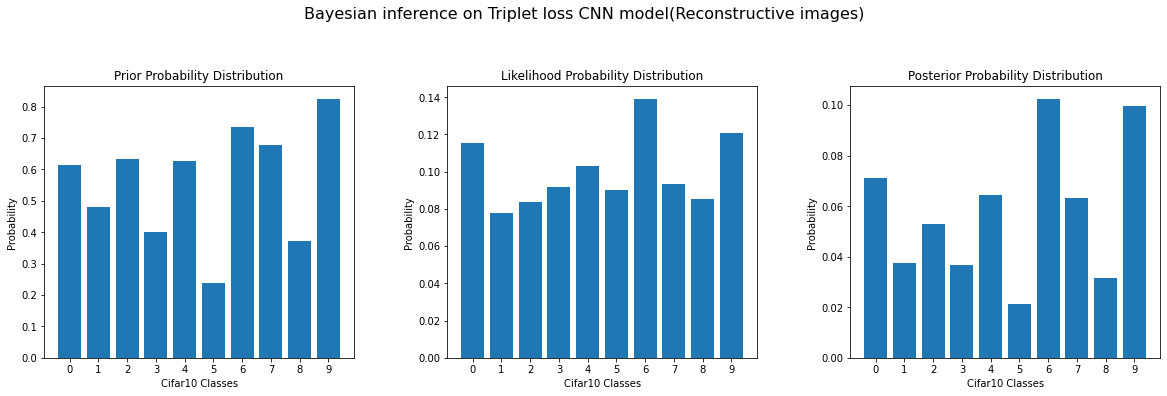

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.subplots_adjust(wspace=0.3)

# Add main title
fig.suptitle('Bayesian inference on Triplet loss CNN model(Reconstructive images)', fontsize=16, y=1.1)

# Plot the train and val loss in the first subplot
axs[0].bar(range(10), prior_probs)
axs[0].set_title('Prior Probability Distribution')
axs[0].set_xlabel('Cifar10 Classes')
axs[0].set_ylabel('Probability')
axs[0].set_xticks(range(10))
axs[0].set_xticklabels(range(10))

axs[1].bar(range(10), likelihood_probs)
axs[1].set_title('Likelihood Probability Distribution')
axs[1].set_xlabel('Cifar10 Classes')
axs[1].set_ylabel('Probability')
axs[1].set_xticks(range(10))
axs[1].set_xticklabels(range(10))

axs[2].bar(range(10), posterior_probs)
axs[2].set_title('Posterior Probability Distribution')
axs[2].set_xlabel('Cifar10 Classes')
axs[2].set_ylabel('Probability')
axs[2].set_xticks(range(10))
axs[2].set_xticklabels(range(10))

plt.savefig('Bayesian inference on Triplet loss CNN model(Reconstructive images).jpeg', bbox_inches='tight')

In [24]:
q = posterior_probs
q = q.tolist()

In [25]:
pg = [0.1, 0.1, 0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

In [26]:
from scipy.special import rel_entr

#calculate (P || Q)
print("KL divergence:",sum(rel_entr(pg, q)),'nats')

KL divergence: 0.6533670139018912 nats
